# Biomass Estimation - Putting the RAT into TPOT  
<img src='http://www.auscover.org.au/wp-content/themes/auscover/assets/images/logo.png'>


#### A demonstration on linking field data to image data using machine learning
_DISCLAIMER: This is only a demonstration of some cool data science methods you can pull off on your laptop at home, and not about the science of Biomass estimation. There are some very good scientists and programs looking at how to improve biomass estimation and better quantify the error budget. Whatever comes out of the bottom of this worksheet is to be used for your amusement only :)_


_By [Peter Scarth](mailto:p.scarth@uq.edu.au?subject=AEOCCG%20webinar%20information) (Joint Remote Sensing Research Program) _

### Abstract

This is a quick and dirty notebook demonstrating how to link two data sets I pulled off the [AusCover](http://auscover.org.au) portal. In particular, I wanted to show how powerful the combination of Raster Attribute Tables (RATs) and Machine Learning (ML) is for getting quick insights into data at a national scale.  I pulled this together one Sunday night so it's not necessarily pretty or efficient but it might give someone else a heads up into getting started with integrated ecological data science using [TERN](http://www.tern.org.au/) data.

This uses a number of awesome python libraries. I'd really recommend [conda](https://conda.io/) to get going, or if you like Docker pull my [datascience-rs](https://hub.docker.com/r/petescarth/datascience-rs/) container that has everything you need to run this installed.


#### Raster Attribute Tables
For an excellent introduction to RATs I recommend the following paper:

Clewley, D.; Bunting, P.; Shepherd, J.; Gillingham, S.; Flood, N.; Dymond, J.; Lucas, R.; Armston, J.; Moghaddam, M. _A Python-Based Open Source System for Geographic Object-Based Image Analysis (GEOBIA) Utilizing Raster Attribute Tables_. [__Remote Sensing 2014, 6, 6111-6135__](http://www.mdpi.com/2072-4292/6/7/6111). 

RATs work well with machine learning and quick data analysis. To run the prediction across the continent using this notebook takes about __3 minutes__ when working on the RAT. It would take around 6000x longer or nearly __2 weeks__ to process the image on a per-pixel basis.

If you want a lightweight raster GIS with powerful RAT manipulation abilities have a look at [Tuiview](http://tuiview.org/)

#### Machine Learning
I really like[TPOT](http://rhiever.github.io/tpot/) for this sort of analysis. It's close to magical for me. You can possibly do better through careful ML pipeline selection and tuning but it really helps to get you started.
_"Consider TPOT your Data Science Assistant. TPOT is a Python tool that automatically creates and optimizes machine learning pipelines using genetic programming."_

#### Biomass Library
The [Biomass Plot Library](http://www.auscover.org.au/purl/biomass-plot-library) is  a national collation of tree and shrub inventory data, allometric model predictions of above and below-ground biomass for Australia. More data is being added all the time.

The data in this notebook was extracted using the [Field Data Portal](http://qld.auscover.org.au/public/html/field/). I selected the __Biomass__ Library and then the __Site Level__ Dataset.  I downloaded the whole lot as a csv file and that' file is what I use here.

<img src=http://www.auscover.org.au/wp-content/uploads/biomass-plot-library.jpg>

#### Height and Structure Data
The [Vegetation height and structure - derived from ALOS-1 PALSAR, Landsat and ICESat/GLAS, Australia](http://auscover.org.au/purl/icesat-vegetation-structure  ) contains vertical plant profiles for the Australian continent derived through integration of ICESat GLAS waveforms with ALOS PALSAR and Landsat data products. 

There are individual tiff files of the various parameters available for download, but you're going to want the  [KEA](http://www.gdal.org/frmt_kea.html) file of all the parameters and the segments (__alpsbk_aust_y2009_sc5a2.kea__) which is available [here](http://qld.auscover.org.au/public/data/spatial_other/jrsrp/height/alpsbk_aust_y2009_sc5a2.kea) as a __9.1 G__ download.  I'm yet to work out how to efficiently access kea files over the internet, like we do using the /vsicurl/ driver for GeoTIFF, so for now you'll need to download it.


<img src=http://www.auscover.org.au/wp-content/uploads/Vegetation-height-and-structure.jpg>

In [1]:
# Imports for this Python3 notebook
import numpy
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import ogr
from osgeo import osr

from rios import rat
from rios import ratapplier

from tpot import TPOTRegressor


## Prepare the training data
This section reads in the Biomass library csv file and links the observations to the closest segment. _No consideration is made of the size or shape of the field plot or the shapes of the segments!_

The Biomass Library has the following fields:
`longitude,latitude,live_basal_area_ha,dead_basal_area_ha,live_tree_density_ha,dead_tree_density_ha,
agb_drymass_ha,agb_drymass_se_ha,bgb_drymass_ha,bgb_drymass_se_ha,tb_drymass_ha,tb_drymass_se_ha`  

Once we find the closest segment, we extract the attributes we want from the RAT to aget an _imageData_ array to match with the _fieldBiomass_ array.


In [2]:
# Read Biomass library data from the csv file 
fieldBiomass=numpy.loadtxt("biolib_sitelist_auscover.csv",delimiter=',', skiprows=1)

# Open Height Map dataset
keaFile = "alpsbk_aust_y2009_sc5a2.kea"

heightDataset = gdal.Open(keaFile, gdal.GA_Update)


# Set up the reprojection transform from WGS84 (biomass library) to Australian Albers (height data)
source = osr.SpatialReference()
source.ImportFromEPSG(4326)
target = osr.SpatialReference()
target.ImportFromEPSG(3577)
transform = osr.CoordinateTransformation(source, target)


# Open the raster band with the segment IDs
heightBand=heightDataset.GetRasterBand(1)

# Get the Albers to pixel transform
geoTransform=heightDataset.GetGeoTransform()

# Find the segmentID for all the field sites
print("Linking field observations to segment IDs\n")
segmentIDs = []
for record in fieldBiomass:
    # Make up a site OGR point
    site = ogr.Geometry(ogr.wkbPoint)
    site.AddPoint(record[0], record[1])
    # Transform the site to EPSG3577
    site.Transform(transform)
    # Get the pixel location of the site
    mx,my=site.GetX(), site.GetY()  #coord in map units
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - geoTransform[0]) / geoTransform[1]) #x pixel
    py = int((my - geoTransform[3]) / geoTransform[5]) #y pixel
    # Extract the segmentID for the location
    segmentIDs.append(heightBand.ReadAsArray(px,py,1,1)[0][0])

# Get the RAT column names
colNames = rat.getColumnNames(heightDataset)

# Select the columns used for the training/prediction
trainingColumns = [5,6,7,8,9,10,15,19,22,23,25,26,27,28,29,30,31,32,33,34]
trainingNames = [colNames[i] for i in trainingColumns]

# Now we have the segmentIDs, pull the image data from the RAT that corresponds to the segment IDs
imageData = []
# Iterate for all the RAT columns
for name in trainingNames:
    print("Extracting sites from " + name)
    # Extract the array of values corresponding to the field site segments
    imageData.append(rat.readColumnFromBand(heightBand,name).astype('float')[segmentIDs])

# Convert the list of arrays to an array
imageData = numpy.transpose(numpy.array(imageData))

# Remove nodata from the couple of segments too small to get statistics in the image data
goodDataIDX = imageData.min(axis=1)>0
imageData = imageData[goodDataIDX]
fieldBiomass = fieldBiomass[goodDataIDX]


print("\nTraining data has %d observations and %d columns" % imageData.shape)

Linking field observations to segment IDs

Extracting sites from PGmean
Extracting sites from PGsd
Extracting sites from HHmean
Extracting sites from HHsd
Extracting sites from HVmean
Extracting sites from HVsd
Extracting sites from rhogc1000
Extracting sites from fcovc1000
Extracting sites from rhovc1000
Extracting sites from gSDc1000
Extracting sites from fcov_10_30c1000
Extracting sites from fcov_totalc1000
Extracting sites from fcov_30plusc1000
Extracting sites from fcov_0_5c1000
Extracting sites from fcov_5_10c1000
Extracting sites from hp50c1000satcor
Extracting sites from hp75c1000satcor
Extracting sites from hp95c1000satcor
Extracting sites from hp25c1000satcor
Extracting sites from hModec1000satcor

Training data has 14373 observations and 20 columns


## Build the Machine Learning Model
This uses the amazing [TPOT](https://github.com/rhiever/tpot) tool to find a good machine learning pipeline that predicts biomass. It automates the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data. There are a few setting below to tweak.  
  - _optTime_ is the number of minutes you are prepared to wait for the optimisation. The longer the better.
  - _nCPUs_ is the number of CPUs you have available for the search. You'll also need a minimum of about 2GB of RAM per CPU
  - _Scoring_ is the thing you'll be minimising
  - _nSubsets_ picks a random subset from the training data. Smaller is faster but you might miss some variation in the data
  - The field from the biomass library you want to fit. Here we're selecting the __Total Biomass__ column (number 10)

This will run a genetic algorithm until it times out and selects the best fitting model to use for biomass prediction. It saves the model so you can play with it later if you want.

Optimization Progress: 100%|██████████| 200/200 [08:47<00:00,  4.23s/pipeline]

Generation 1 - Current best internal CV score: 170815.6565023425


Optimization Progress: 100%|██████████| 300/300 [09:46<00:00,  1.06pipeline/s]

Generation 2 - Current best internal CV score: 170815.6565023425


Optimization Progress: 100%|██████████| 400/400 [11:25<00:00,  2.51s/pipeline]

Generation 3 - Current best internal CV score: 170815.6565023425


Optimization Progress: 100%|██████████| 500/500 [12:21<00:00,  1.61pipeline/s]

Generation 4 - Current best internal CV score: 170815.6565023425


Optimization Progress: 100%|██████████| 600/600 [13:29<00:00,  1.26s/pipeline]

Generation 5 - Current best internal CV score: 170277.62893992377


Optimization Progress: 100%|██████████| 700/700 [14:19<00:00,  2.80pipeline/s]

Generation 6 - Current best internal CV score: 170277.62893992377


Optimization Progress: 100%|██████████| 800/800 [16:01<00:00,  1.83s/pipeline]

Generation 7 - Current best internal CV score: 170277.62893992377



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(SelectFromModel(input_matrix, SelectFromModel__ExtraTreesRegressor__max_features=0.35, SelectFromModel__threshold=0.1), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=7, RandomForestRegressor__min_samples_split=9)
Total RMSE = 375.378749

Start  Stop Count  RMSE
    0   100  4069   121
  100   500  8719   151
  500  1000  1020   344
 1000  2000   348   663
 2000  5000   174  1558
 5000 10000    38  4343


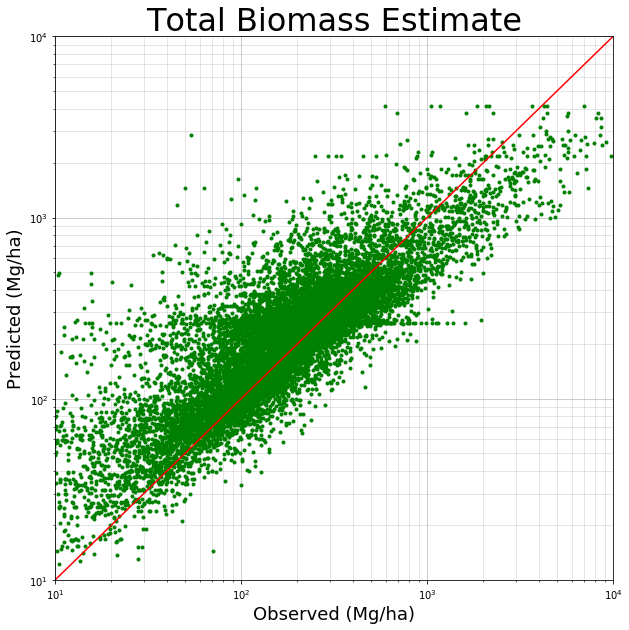

In [5]:
# Total amount of time we allow for the training
optTime = 15

# Number of CPUs to use for training and cross validation
nCPUs = 4

# What function to minimise
scoring = 'mean_squared_error'

# Number of subsamples from the Biomass Library for model training
nSubsets = 5000

# We select the tb_drymass_ha column to train on
totalBiomass = fieldBiomass[:,10]
# This is the standard error of the site level estimates
totalBiomassSE = fieldBiomass[:,11]

# Select a subsample to improve the model search speed
subSample = numpy.random.choice(len(totalBiomass),nSubsets,replace=False)
biomass=totalBiomass[subSample]
biomassSE=totalBiomassSE[subSample]
trainData=imageData[subSample]

# Use the proportion of the error in the estimates as fitting weights
biomassWeights=biomass/biomassSE

# Setup the TPOT regression options
tpot = TPOTRegressor(max_time_mins=optTime,  
                     n_jobs = nCPUs, 
                     scoring=scoring, 
                     verbosity=2, 
                     cv=10, 
                     max_eval_time_mins=1, 
                     population_size=100)

# Start testing models using 10 fold cross validation and 100 models per generation
tpot.fit(trainData, biomass, sample_weight=biomassWeights)

# Export the best model to a file
tpot.export('tpot_biomass_pipeline.py')

# Build the biomass predictive model
biomassModel = tpot._fitted_pipeline.fit(imageData, totalBiomass)

# Predict the full dataset
predBiomass = biomassModel.predict(imageData)

# Print some RMSE Statistics for various ranges
print("Total RMSE = %f\n" % numpy.sqrt(numpy.mean((totalBiomass-predBiomass)**2)))
stopPoints=[0,100,500,1000,2000,5000,10000]
print("Start"," Stop","Count"," RMSE")
for i in range(len(stopPoints)-1):
    idx=numpy.logical_and(totalBiomass>stopPoints[i],totalBiomass<stopPoints[i+1])
    rmse=numpy.sqrt(numpy.mean((totalBiomass[idx]-predBiomass[idx])**2))
    print('{0:5d} {1:5d} {2:5d} {3:5.0f}'.format(stopPoints[i],stopPoints[i+1],idx.sum(),rmse))



# Plot the Output in a LogLog figure
fig = plt.figure(figsize=(10,10))
plt.loglog(totalBiomass,predBiomass, 'g.',[10,10000], [10,10000],'r-')
plt.xlabel('Observed (Mg/ha)', fontsize=18)
plt.ylabel('Predicted (Mg/ha)', fontsize=18)
plt.title('Total Biomass Estimate', fontsize=32)
plt.xlim([10,10000])
plt.ylim([10,10000])
plt.grid(which='minor', alpha=0.4)                                                
plt.grid(which='major', alpha=0.8)                                                

## Predict Biomass using the RAT
Once we have the _biomassModel_ we can use that to predict the Biomass for every entry in the RAT. 

This is cool, because for Australia we only need to make around 3,000,000 predictions which is far faster than predicting every one of the 18,407,102,543 pixels in the image. That's around a __6000x__ speedup.

Here,  [RIOS](http://rioshome.org) ratapplier does the work writing a brand new attribute column into the kea file.

In [6]:
%%time

def _ratapplier_calc_biomass(info, inputs, outputs):
    """
    Calculate Biomass from RAT.
    Called by ratapplier below
    """
    ratArray = []
    # Iterate for all the RAT columns
    for name in trainingNames:
        # Extract the array of values corresponding to the field site segments
        ratArray.append(getattr(inputs.inrat, name).astype('float'))

    # Convert the list of arrays to an array
    ratArray = numpy.transpose(numpy.array(ratArray))
    # Predict Biomass
    biomass = biomassModel.predict(ratArray)
    # Make the weird inputs nodata
    biomass[ratArray.min(axis=1) < numpy.finfo(numpy.float32).eps] = 0

    # Save to 'totalBiomass' column (will create if doesn't exist)
    setattr(outputs.outrat,"totalBiomass", biomass)


# Set up ratapplier for input / output
inFile = ratapplier.RatAssociations()
outFile = ratapplier.RatAssociations()

# Pass in clumps file for the input and output as we'll be updating the existing RAT
inFile.inrat = ratapplier.RatHandle(keaFile)
outFile.outrat = ratapplier.RatHandle(keaFile)

# Apply function to all rows in chunks
ratapplier.apply(_ratapplier_calc_biomass, inFile, outFile)
    
    

CPU times: user 1min 29s, sys: 3.05 s, total: 1min 32s
Wall time: 1min 39s


## Export the Biomass band to an individual GeoTIFF
You can run this section if you want to output just the newly calculated biomass column to a separate GeoTIFF. 

This uses one of the function from the rastergis module in [RSGISLIB](http://www.rsgislib.org/)

After this, you might like to run __gdal_translate__ to compress the output and __gdaladdo__ to add overviews for easy storage and fast viewing in your favorite GIS platform. Like this:
```
gdal_translate -a_nodata 0 -of GTIFF -co COMPRESS=DEFLATE -co ZLEVEL=9 -co TILED=YES totalBiomass.tif totalBiomassCompressed.tif

gdaladdo -r average --config TILED_OVERVIEW YES --config COMPRESS_OVERVIEW PACKBITS totalBiomassCompressed.tif 4 8 16 32 64 128 256 512

```

If everything has worked, you should have a file that looks something like this:

<img src=https://pbs.twimg.com/media/C-s2iyTUwAAxNzb.jpg>




In [ ]:
# Additional Imports
import rsgislib
from rsgislib.rastergis import exportCol2GDALImage

# Setup the export parameters
outimage='/home/jovyan/work/Temp/totalBiomass.tif'
gdalformat = 'GTIFF'
datatype = rsgislib.TYPE_16UINT
field = 'totalBiomass'

# Run the export
exportCol2GDALImage(keaFile, outimage, gdalformat, datatype, field)